In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime

In [2]:
os.listdir(".")

['.git',
 '.gitignore',
 'Bushfire_Impact_Water_Data.ipynb',
 'Humor-Sans.ttf',
 'Info for project',
 'Lake Conjola Data Set.ipynb',
 'lake_data',
 'LICENSE',
 'maps',
 'maps.ipynb',
 'penalty_data_set_0.csv',
 'README.md',
 'tricks.ipynb',
 'tricks.py']

In [3]:
folder = "lake_data"
all_dataframes = []
for file_name in os.listdir(folder):
    path = os.path.join(folder, file_name)
    print(path)
    df = pd.read_csv(path, parse_dates=[0])
    df.columns = [
        "dateTime",
        "estuaryName",
        "siteID",
        "loggerID",
        "sampleDepth",
        "conductivity",
        "temp",
        "density",
    ]
    df["source_file"] = file_name
    all_dataframes.append(df)

lake_data\LC_Bushfire_Water_Quality_Data.csv
lake_data\ML_Bushfire_Water_Quality_Data.csv
lake_data\Turmeil_Lake_Bushfire_Water_Quality.csv
lake_data\Tuross_Lake_Bushfire_Water_Quality_Data.csv


In [4]:
all_dataframes[0]

,dateTime,estuaryName,siteID,loggerID,sampleDepth,conductivity,temp,density,source_file
0,2020-01-20 12:30:00,Lake Conjola,CON1,CON1-Surface,0.5,35444.2,24.95,7.23,LC_Bushfire_Water_Quality_Data.csv
1,2020-01-20 12:45:00,Lake Conjola,CON1,CON1-Surface,0.5,34664.3,25.01,7.64,LC_Bushfire_Water_Quality_Data.csv
2,2020-01-20 13:00:00,Lake Conjola,CON1,CON1-Surface,0.5,34318.8,25.03,7.66,LC_Bushfire_Water_Quality_Data.csv
3,2020-01-20 13:15:00,Lake Conjola,CON1,CON1-Surface,0.5,34164.1,25.06,7.66,LC_Bushfire_Water_Quality_Data.csv
4,2020-01-20 13:30:00,Lake Conjola,CON1,CON1-Surface,0.5,34044.5,25.04,7.67,LC_Bushfire_Water_Quality_Data.csv
...,...,...,...,...,...,...,...,...,...
2682,2020-02-17 11:00:00,Lake Conjola,CON1,CON1-Surface,0.5,529.2,24.76,4.08,LC_Bushfire_Water_Quality_Data.csv
2683,2020-02-17 11:15:00,Lake Conjola,CON1,CON1-Surface,0.5,528.3,24.75,3.86,LC_Bushfire_Water_Quality_Data.csv
2684,2020-02-17 11:30:00,Lake Conjola,CON1,CON1-Surface,0.5,527.9,24.74,4.03,LC_Bushfire_Water_Quality_Data.csv
2685,2020-02-17 11:45:00,Lake Conjola,CON1,CON1-Surface,0.5,526.9,24.76,4.14,LC_Bushfire_Water_Quality_Data.csv


In [5]:
all_lakes_df = pd.concat(all_dataframes)
all_lakes_df.sample(4)

,dateTime,estuaryName,siteID,loggerID,sampleDepth,conductivity,temp,density,source_file
776,2020-01-29 19:00:00,Termeil Lake,TER1,TER1-Surface,0.5,NaN,29.10,8.43,Turmeil_Lake_Bushfire_Water_Quality.csv
2072,2020-12-02 07:00:00,Termeil Lake,TER1,TER1-Surface,0.5,NaN,22.24,4.95,Turmeil_Lake_Bushfire_Water_Quality.csv
337,2020-01-24 00:45:00,Lake Conjola,CON1,CON1-Surface,0.5,33418.5,25.57,7.60,LC_Bushfire_Water_Quality_Data.csv
2036,2020-10-02 17:30:00,Lake Conjola,CON1,CON1-Surface,0.5,434.2,21.06,6.51,LC_Bushfire_Water_Quality_Data.csv


In [6]:
type(df.dateTime[0])

pandas._libs.tslibs.timestamps.Timestamp

<AxesSubplot:xlabel='dateTime'>

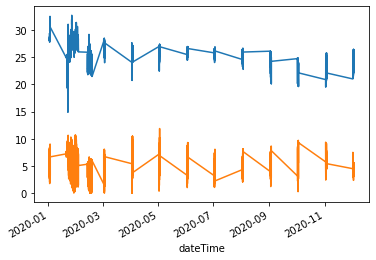

In [7]:
all_lakes_df.set_index("dateTime").temp.plot()
all_lakes_df.set_index("dateTime").density.plot()

Lake Conjola (2687, 9)
Meroo Lake (2581, 9)
Termeil Lake (2591, 9)
Tuross River (2643, 9)


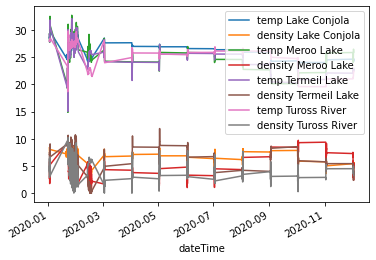

In [8]:
for name, df in all_lakes_df.groupby("estuaryName"):
    print(name, df.shape)
    df.set_index("dateTime").temp.plot(label=f"temp {name}")
    df.set_index("dateTime").density.plot(label=f"density {name}")
plt.legend()